In [ ]:
# TS Analysis
# OLS fit for price prediction
# signal analysis and prediction
# profit calculation project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader as dr
from pandas_datareader import data
from datetime import datetime
import cvxopt as opt
from cvxopt import blas, solvers
# import requests_cache

In [3]:
# Create a list of the ticker symbols to be used in this project
tickers = ['AMZN', 'GOOGL', 'JNJ', 'V', 'PG', 'UNH', 'JPM', 'HD', 'VZ', 'NFLX', 'DIS', 'MRK', 'PEP', 'BAC', 'KO', 'WMT',
          'CVX', 'ABT', 'AMGN', 'MCD', 'COST', 'NKE', 'PM', 'QCOM', 'LOW', 'BA', 'LMT', 'SBUX', 'UPS', 'CAT']

# tickers_short = ['AMZN', 'GOOGL', 'JNJ', 'V', 'PG']

In [4]:
ticker_length = len(tickers)
pd.set_option('display.max_columns', ticker_length)

In [9]:
# Define start and end date
# end = datetime(2023, 5, 26)
# start = datetime(2019, 8, 6)

start = pd.to_datetime(['2019-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2023-05-19']).astype(int)[0]//10**9 # convert to unix timestamp.

In [10]:
## actual data pull

prices = []
vol = []
df_prices = pd.DataFrame()
df_volumes = pd.DataFrame()


for tick in tickers:
    url = 'https://query1.finance.yahoo.com/v7/finance/download/' + tick + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
    df = pd.read_csv(url)
    df = df.set_index('Date')
    df_prices[tick] = df['Adj Close']
    df_volumes[tick] = df['Volume']

    prices.append(df['Adj Close'])
    vol.append(df['Volume'])


df_prices.columns = tickers
df_volumes.columns = tickers

In [11]:
df_prices.head()

AMZN      GOOGL         JNJ           V         PG  \
Date                                                                  
2019-01-02  76.956497  52.734001  113.289436  128.979141  81.445816   
2019-01-03  75.014000  51.273499  111.489204  124.331146  80.874771   
2019-01-04  78.769501  53.903500  113.360374  129.687454  82.525452   
2019-01-07  81.475502  53.796001  112.633217  132.026031  82.195313   
2019-01-08  82.829002  54.268501  115.249290  132.744080  82.498711   

                   UNH        JPM          HD         VZ        NFLX  \
Date                                                                   
2019-01-02  228.546387  86.554703  155.546707  45.232269  267.660004   
2019-01-03  222.313919  85.324608  152.118347  45.393757  271.200012   
2019-01-04  224.913895  88.470131  156.638351  45.506805  297.570007   
2019-01-07  225.345688  88.531639  159.723862  45.797470  315.339996   
2019-01-08  228.358643  88.364693  160.490677  47.137806  320.269989   

                   DIS        MRK        PEP        BAC         KO        WMT  \
Date                                                                            
2019-01-02  107.654335  63.185005  96.932426  22.641020  41.098732  86.520966   
2019-01-03  105.046211  61.889370  96.027695  22.278181  40.844780  86.076042   
2019-01-04  108.286606  63.753418  97.996841  23.203411  41.659222  86.613655   
2019-01-07  109.225136  63.051250  97.154182  23.185274  41.116261  87.633293   
2019-01-08  110.074760  63.519367  98.085548  23.139921  41.580406  88.245071   

                  CVX        ABT        AMGN         MCD        COST  \
Date                                                                   
2019-01-02  90.628799  64.570145  167.338028  159.459518  192.415695   
2019-01-03  88.893013  61.522789  164.791779  158.408905  188.337387   
2019-01-04  90.735252  63.278736  170.424927  161.470200  193.806564   
2019-01-07  91.914261  64.226379  172.718338  163.227295  194.520737   
2019-01-08  91.513046  63.455261  174.933197  163.571487  195.977280   

                  NKE         PM       QCOM        LOW          BA  \
Date                                                                 
2019-01-02  71.081741  53.021290  51.560314  85.181480  314.645142   
2019-01-03  69.824417  52.335987  50.033264  84.165977  302.100525   
2019-01-04  71.648003  54.785786  50.841705  86.658562  317.822571   
2019-01-07  72.674980  53.107944  50.697983  88.301796  318.823395   
2019-01-08  73.644356  53.462421  50.257843  90.129692  330.891937   

                   LMT       SBUX        UPS         CAT  
Date                                                      
2019-01-02  236.479187  58.850693  84.561768  113.021957  
2019-01-03  230.538864  56.297939  82.160873  108.666710  
2019-01-04  236.756180  58.164474  85.022820  114.604874  
2019-01-07  239.471695  58.164474  84.735741  114.676437  
2019-01-08  241.070709  58.210213  84.744438  116.053650

In [15]:
df_prices.tail()

AMZN       GOOGL         JNJ           V          PG  \
Date                                                                     
2023-05-12  110.260002  117.510002  159.576004  231.380005  155.960007   
2023-05-15  111.199997  116.510002  158.355209  232.809998  156.009995   
2023-05-16  113.400002  119.510002  158.146774  230.470001  155.740005   
2023-05-17  115.500000  120.839996  157.799408  232.649994  155.080002   
2023-05-18  118.150002  122.830002  157.293213  233.600006  152.529999   

                   UNH         JPM          HD         VZ        NFLX  \
Date                                                                    
2023-05-12  491.230011  134.100006  290.470001  37.590000  339.890015   
2023-05-15  486.859985  135.229996  288.540009  36.770000  335.890015   
2023-05-16  479.720001  134.320007  282.329987  36.049999  333.750000   
2023-05-17  484.809998  138.449997  292.390015  36.180000  339.959991   
2023-05-18  479.230011  139.500000  295.160004  36.130001  371.290009   

                  DIS         MRK         PEP        BAC         KO  \
Date                                                                  
2023-05-12  91.989998  117.139999  196.119995  27.090000  64.110001   
2023-05-15  92.860001  116.370003  194.270004  27.650000  63.939999   
2023-05-16  90.980003  116.080002  193.429993  27.360001  63.220001   
2023-05-17  92.769997  114.760002  192.059998  28.570000  63.150002   
2023-05-18  93.760002  114.000000  191.559998  28.469999  62.799999   

                   WMT         CVX         ABT        AMGN         MCD  \
Date                                                                     
2023-05-12  153.070007  155.101166  110.489998  230.772614  296.140015   
2023-05-15  151.880005  155.675552  109.839996  231.347183  295.899994   
2023-05-16  149.779999  152.021332  109.389999  225.750000  294.149994   
2023-05-17  149.529999  154.200012  108.820000  225.020004  293.459991   
2023-05-18  151.470001  154.009995  108.470001  224.229996  294.049988   

                  COST         NKE         PM        QCOM         LOW  \
Date                                                                    
2023-05-12  504.070007  120.209999  95.120003  103.620003  203.259995   
2023-05-15  502.040009  119.830002  95.000000  106.279999  201.550003   
2023-05-16  496.149994  116.480003  93.860001  103.790001  199.220001   
2023-05-17  495.000000  116.980003  93.489998  104.809998  207.199997   
2023-05-18  498.100006  118.870003  92.599998  106.959999  209.160004   

                    BA         LMT        SBUX         UPS         CAT  
Date                                                                    
2023-05-12  200.699997  450.790009  106.120003  168.500000  209.539993  
2023-05-15  202.770004  451.920013  106.639999  168.850006  211.289993  
2023-05-16  200.869995  447.730011  105.279999  166.610001  207.199997  
2023-05-17  206.869995  457.299988  105.690002  171.360001  212.100006  
2023-05-18  207.240005  455.750000  107.089996  171.039993  214.720001

In [13]:
df_volumes.head()

AMZN     GOOGL      JNJ         V        PG      UNH  \
Date                                                                    
2019-01-02  159662000  31868000  7631700   8788000   9843900  4063600   
2019-01-03  139512000  41960000  8654500   9428300   9820200  4623200   
2019-01-04  183652000  46022000  8831700  11065800  10565700  5367600   
2019-01-07  159864000  47446000  8404700  12928000   9012500  4133000   
2019-01-08  177628000  35414000  9351600   9243000   9551300  3618600   

                 JPM       HD        VZ      NFLX       DIS       MRK  \
Date                                                                    
2019-01-02  15670900  4242900  13969700  11679500   9723500  15120125   
2019-01-03  16286400  4810500  19245400  14969600  10594700  13910628   
2019-01-04  16935200  4762600  17035800  19330100  10122800  14753115   
2019-01-07  15430700  4928800  16349000  18620100   6714700  15795142   
2019-01-08  13578800  4722400  21424600  15359200   8730700  11896686   

                PEP       BAC        KO      WMT      CVX       ABT     AMGN  \
Date                                                                           
2019-01-02  4835400  71836300  11603700  8152700  6384800   8737200  3009100   
2019-01-03  5975900  66599600  14714400  8277300  6496200  10570700  3973900   
2019-01-04  6293900  83829100  13013700  8029100  7952500   8299100  4193400   
2019-01-07  5220300  57016300  13135500  7789700  5712700   9503000  3032500   
2019-01-08  6407700  67339400  15420700  7200900  5674900   8905100  3290300   

                MCD     COST      NKE       PM      QCOM      LOW       BA  \
Date                                                                         
2019-01-02  2571500  2143100  6762700  6471200   9896600  4198200  3292200   
2019-01-03  3728200  2877700  8007400  6178200  14422200  3798900  5705600   
2019-01-04  3194300  2761600  7844200  7220700  14177300  4107400  4448800   
2019-01-07  3283000  2226600  8184800  7807200  12352000  4885000  4030300   
2019-01-08  2941400  2366500  8809000  7257700  12110000  4663500  4736500   

                LMT      SBUX      UPS      CAT  
Date                                             
2019-01-02  1064700  10094000  3297300  4783200  
2019-01-03  1165600  14390100  2705000  6165800  
2019-01-04  1443800  12694400  3347300  5456600  
2019-01-07  1465200  10337600  3795700  4653400  
2019-01-08  1791400  10809700  3034300  4202600

In [14]:
df_prices.isna().sum()

AMZN     0
GOOGL    0
JNJ      0
V        0
PG       0
UNH      0
JPM      0
HD       0
VZ       0
NFLX     0
DIS      0
MRK      0
PEP      0
BAC      0
KO       0
WMT      0
CVX      0
ABT      0
AMGN     0
MCD      0
COST     0
NKE      0
PM       0
QCOM     0
LOW      0
BA       0
LMT      0
SBUX     0
UPS      0
CAT      0
dtype: int64

In [ ]:
# want normalized pricces
# want price return
# want log return
# profit project

# dont forget that more than just stock data is available for the analysis

Text(0.5, 1.0, 'Raw Price Data')

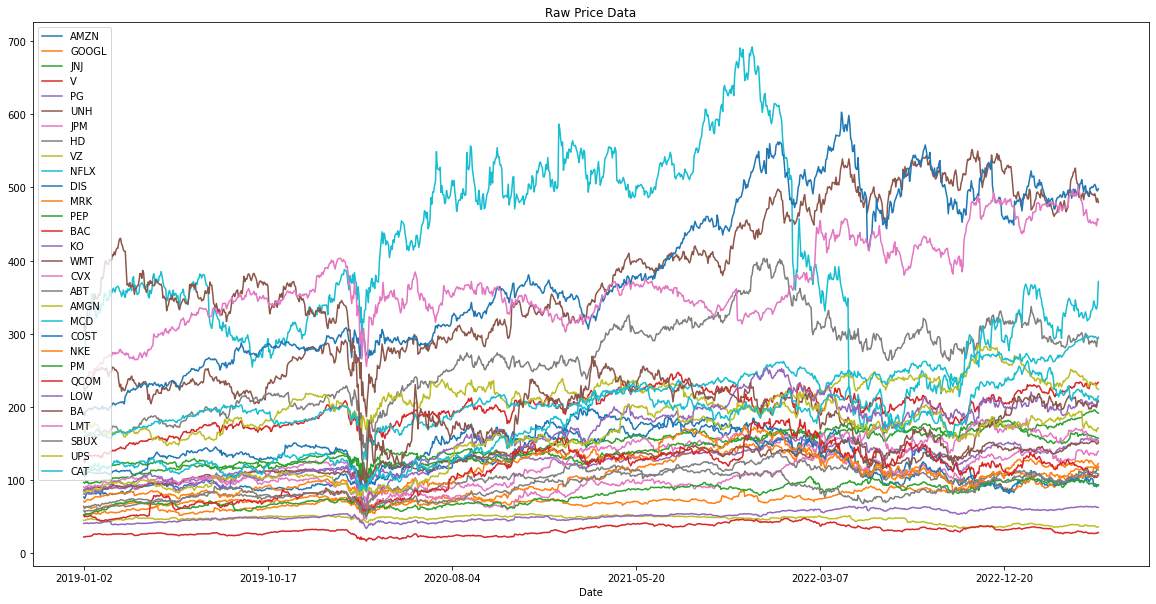

In [20]:
# normalized:

df_prices.plot(figsize = (20, 10))
plt.title('Raw Price Data')

Text(0.5, 1.0, 'Normalized Data')

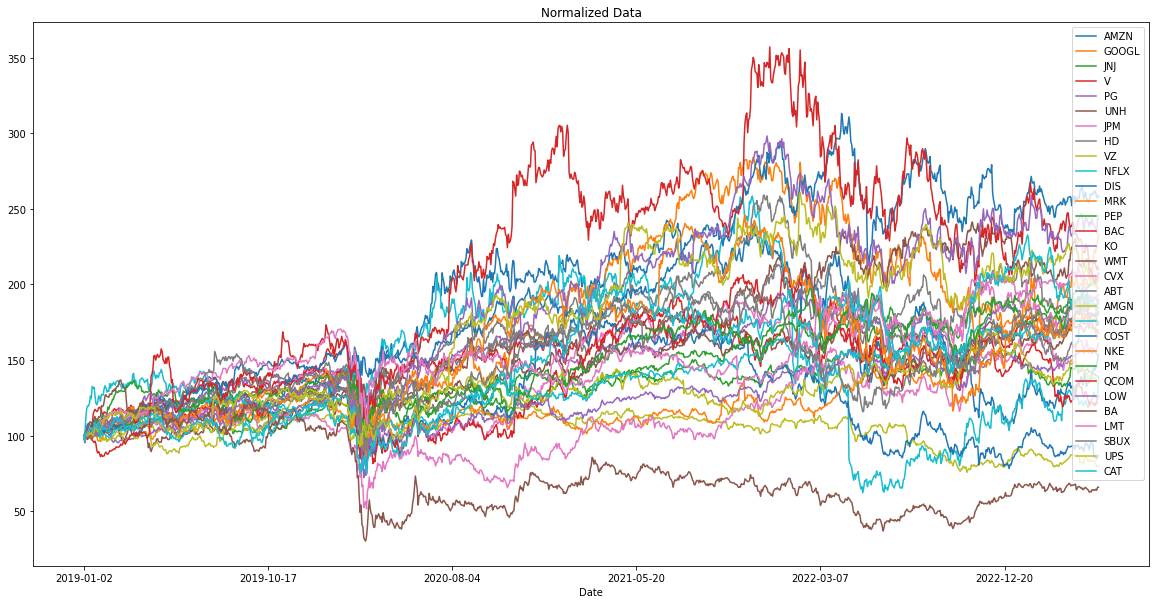

In [57]:
norm_df = df_prices / df_prices.iloc[0] * 100
norm_df.plot(figsize = (20, 10))
plt.title('Normalized Data')

In [58]:
norm_df.index = pd.to_datetime(norm_df.index)
norm_df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-05-05', '2023-05-08', '2023-05-09', '2023-05-10',
               '2023-05-11', '2023-05-12', '2023-05-15', '2023-05-16',
               '2023-05-17', '2023-05-18'],
              dtype='datetime64[ns]', name='Date', length=1103, freq=None)

<AxesSubplot:xlabel='Date'>

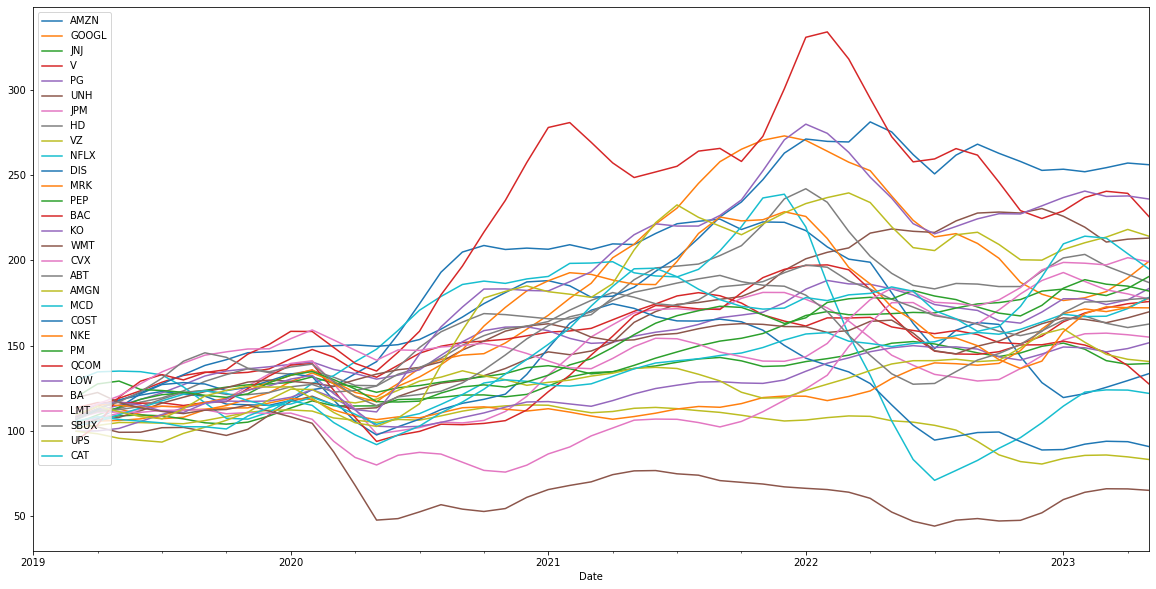

In [59]:
norm_df.resample('M').mean().rolling(window = 3).mean().plot(figsize = (20, 10))

In [60]:
df_pcts = df_prices.pct_change()
df_pcts

AMZN     GOOGL       JNJ         V        PG       UNH  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.025241 -0.027696 -0.015891 -0.036037 -0.007011 -0.027270   
2019-01-04  0.050064  0.051294  0.016783  0.043081  0.020410  0.011695   
2019-01-07  0.034353 -0.001994 -0.006415  0.018032 -0.004000  0.001920   
2019-01-08  0.016612  0.008783  0.023226  0.005439  0.003691  0.013370   
...              ...       ...       ...       ...       ...       ...   
2023-05-12 -0.017115  0.008064 -0.001304  0.001602  0.010169  0.005054   
2023-05-15  0.008525 -0.008510 -0.007650  0.006180  0.000321 -0.008896   
2023-05-16  0.019784  0.025749 -0.001316 -0.010051 -0.001731 -0.014665   
2023-05-17  0.018519  0.011129 -0.002196  0.009459 -0.004238  0.010610   
2023-05-18  0.022944  0.016468 -0.003208  0.004083 -0.016443 -0.011510   

                 JPM        HD        VZ      NFLX       DIS       MRK  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.014212 -0.022041  0.003570  0.013226 -0.024227 -0.020505   
2019-01-04  0.036865  0.029714  0.002490  0.097234  0.030847  0.030119   
2019-01-07  0.000695  0.019698  0.006387  0.059717  0.008667 -0.011014   
2019-01-08 -0.001886  0.004801  0.029267  0.015634  0.007779  0.007424   
...              ...       ...       ...       ...       ...       ...   
2023-05-12 -0.014333  0.009663 -0.000266 -0.014126 -0.003467 -0.003488   
2023-05-15  0.008426 -0.006644 -0.021814 -0.011769  0.009458 -0.006573   
2023-05-16 -0.006729 -0.021522 -0.019581 -0.006371 -0.020246 -0.002492   
2023-05-17  0.030747  0.035632  0.003606  0.018607  0.019675 -0.011371   
2023-05-18  0.007584  0.009474 -0.001382  0.092158  0.010672 -0.006623   

                 PEP       BAC        KO       WMT       CVX       ABT  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.009334 -0.016026 -0.006179 -0.005142 -0.019153 -0.047195   
2019-01-04  0.020506  0.041531  0.019940  0.006246  0.020724  0.028541   
2019-01-07 -0.008599 -0.000782 -0.013033  0.011772  0.012994  0.014976   
2019-01-08  0.009586 -0.001956  0.011289  0.006981 -0.004365 -0.012006   
...              ...       ...       ...       ...       ...       ...   
2023-05-12  0.003993 -0.010953  0.003915 -0.000326  0.002560  0.003998   
2023-05-15 -0.009433  0.020672 -0.002652 -0.007774  0.003703 -0.005883   
2023-05-16 -0.004324 -0.010488 -0.011261 -0.013827 -0.023473 -0.004097   
2023-05-17 -0.007083  0.044225 -0.001107 -0.001669  0.014331 -0.005211   
2023-05-18 -0.002603 -0.003500 -0.005542  0.012974 -0.001232 -0.003216   

                AMGN       MCD      COST       NKE        PM      QCOM  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.015216 -0.006589 -0.021195 -0.017688 -0.012925 -0.029617   
2019-01-04  0.034183  0.019325  0.029039  0.026117  0.046809  0.016158   
2019-01-07  0.013457  0.010882  0.003685  0.014334 -0.030625 -0.002827   
2019-01-08  0.012824  0.002109  0.007488  0.013339  0.006675 -0.008682   
...              ...       ...       ...       ...       ...       ...   
2023-05-12  0.002841  0.004580  0.004344 -0.016446  0.000842 -0.004228   
2023-05-15  0.002490 -0.000810 -0.004027 -0.003161 -0.001262  0.025671   
2023-05-16 -0.024194 -0.005914 -0.011732 -0.027956 -0.012000 -0.023429   
2023-05-17 -0.003234 -0.002346 -0.002318  0.004293 -0.003942  0.009828   
2023-05-18 -0.003511  0.002010  0.006263  0.016157 -0.009520  0.020513   

                 LOW        BA       LMT      SBUX       UPS       CAT  
Date                                                                    
2019-01-02       N

In [63]:
norm_pcts = norm_df.pct_change()
norm_pcts

AMZN     GOOGL       JNJ         V        PG       UNH  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.025241 -0.027696 -0.015891 -0.036037 -0.007011 -0.027270   
2019-01-04  0.050064  0.051294  0.016783  0.043081  0.020410  0.011695   
2019-01-07  0.034353 -0.001994 -0.006415  0.018032 -0.004000  0.001920   
2019-01-08  0.016612  0.008783  0.023226  0.005439  0.003691  0.013370   
...              ...       ...       ...       ...       ...       ...   
2023-05-12 -0.017115  0.008064 -0.001304  0.001602  0.010169  0.005054   
2023-05-15  0.008525 -0.008510 -0.007650  0.006180  0.000321 -0.008896   
2023-05-16  0.019784  0.025749 -0.001316 -0.010051 -0.001731 -0.014665   
2023-05-17  0.018519  0.011129 -0.002196  0.009459 -0.004238  0.010610   
2023-05-18  0.022944  0.016468 -0.003208  0.004083 -0.016443 -0.011510   

                 JPM        HD        VZ      NFLX       DIS       MRK  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.014212 -0.022041  0.003570  0.013226 -0.024227 -0.020505   
2019-01-04  0.036865  0.029714  0.002490  0.097234  0.030847  0.030119   
2019-01-07  0.000695  0.019698  0.006387  0.059717  0.008667 -0.011014   
2019-01-08 -0.001886  0.004801  0.029267  0.015634  0.007779  0.007424   
...              ...       ...       ...       ...       ...       ...   
2023-05-12 -0.014333  0.009663 -0.000266 -0.014126 -0.003467 -0.003488   
2023-05-15  0.008426 -0.006644 -0.021814 -0.011769  0.009458 -0.006573   
2023-05-16 -0.006729 -0.021522 -0.019581 -0.006371 -0.020246 -0.002492   
2023-05-17  0.030747  0.035632  0.003606  0.018607  0.019675 -0.011371   
2023-05-18  0.007584  0.009474 -0.001382  0.092158  0.010672 -0.006623   

                 PEP       BAC        KO       WMT       CVX       ABT  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.009334 -0.016026 -0.006179 -0.005142 -0.019153 -0.047195   
2019-01-04  0.020506  0.041531  0.019940  0.006246  0.020724  0.028541   
2019-01-07 -0.008599 -0.000782 -0.013033  0.011772  0.012994  0.014976   
2019-01-08  0.009586 -0.001956  0.011289  0.006981 -0.004365 -0.012006   
...              ...       ...       ...       ...       ...       ...   
2023-05-12  0.003993 -0.010953  0.003915 -0.000326  0.002560  0.003998   
2023-05-15 -0.009433  0.020672 -0.002652 -0.007774  0.003703 -0.005883   
2023-05-16 -0.004324 -0.010488 -0.011261 -0.013827 -0.023473 -0.004097   
2023-05-17 -0.007083  0.044225 -0.001107 -0.001669  0.014331 -0.005211   
2023-05-18 -0.002603 -0.003500 -0.005542  0.012974 -0.001232 -0.003216   

                AMGN       MCD      COST       NKE        PM      QCOM  \
Date                                                                     
2019-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-03 -0.015216 -0.006589 -0.021195 -0.017688 -0.012925 -0.029617   
2019-01-04  0.034183  0.019325  0.029039  0.026117  0.046809  0.016158   
2019-01-07  0.013457  0.010882  0.003685  0.014334 -0.030625 -0.002827   
2019-01-08  0.012824  0.002109  0.007488  0.013339  0.006675 -0.008682   
...              ...       ...       ...       ...       ...       ...   
2023-05-12  0.002841  0.004580  0.004344 -0.016446  0.000842 -0.004228   
2023-05-15  0.002490 -0.000810 -0.004027 -0.003161 -0.001262  0.025671   
2023-05-16 -0.024194 -0.005914 -0.011732 -0.027956 -0.012000 -0.023429   
2023-05-17 -0.003234 -0.002346 -0.002318  0.004293 -0.003942  0.009828   
2023-05-18 -0.003511  0.002010  0.006263  0.016157 -0.009520  0.020513   

                 LOW        BA       LMT      SBUX       UPS       CAT  
Date                                                                    
2019-01-02       N

<AxesSubplot:xlabel='Date'>

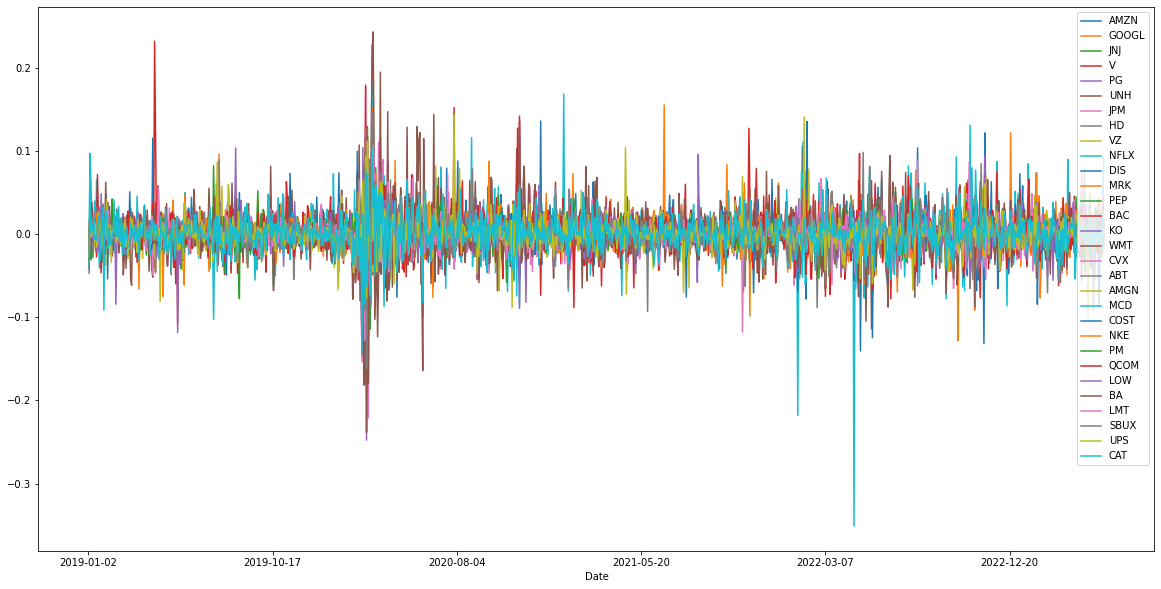

In [64]:
df_pcts.plot(figsize = (20, 10))

In [ ]:
# lets take the 30 day rolling avg
# lets take the 3 month rolling average by day
# lets take the 3 month rolling average by month

<AxesSubplot:xlabel='Date'>

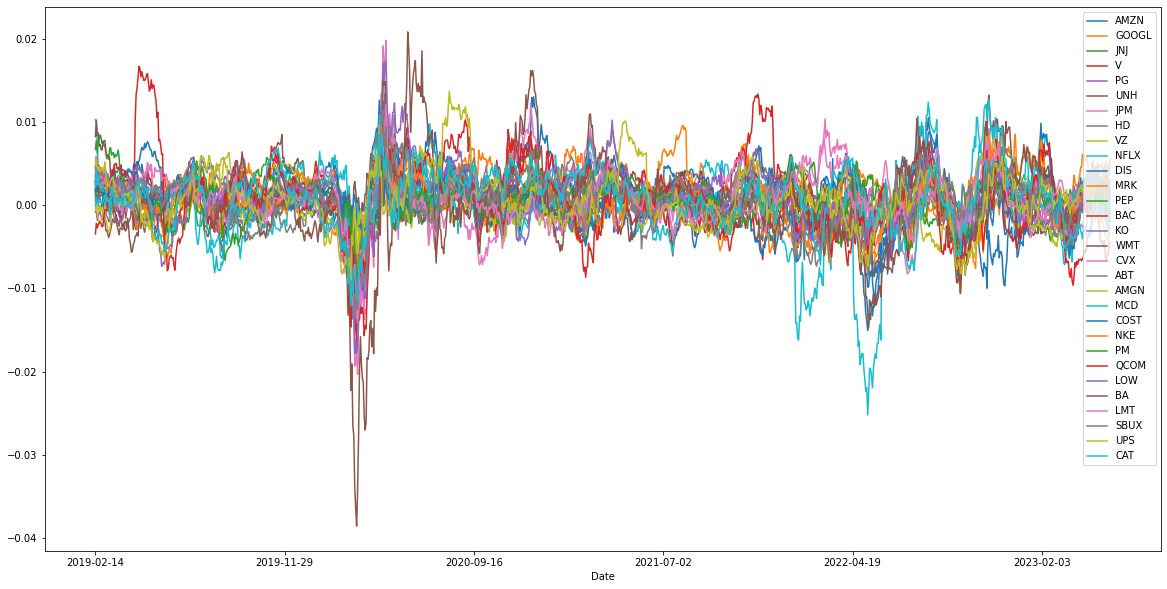

In [69]:
df_pcts.rolling(window = 30).mean().dropna().plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

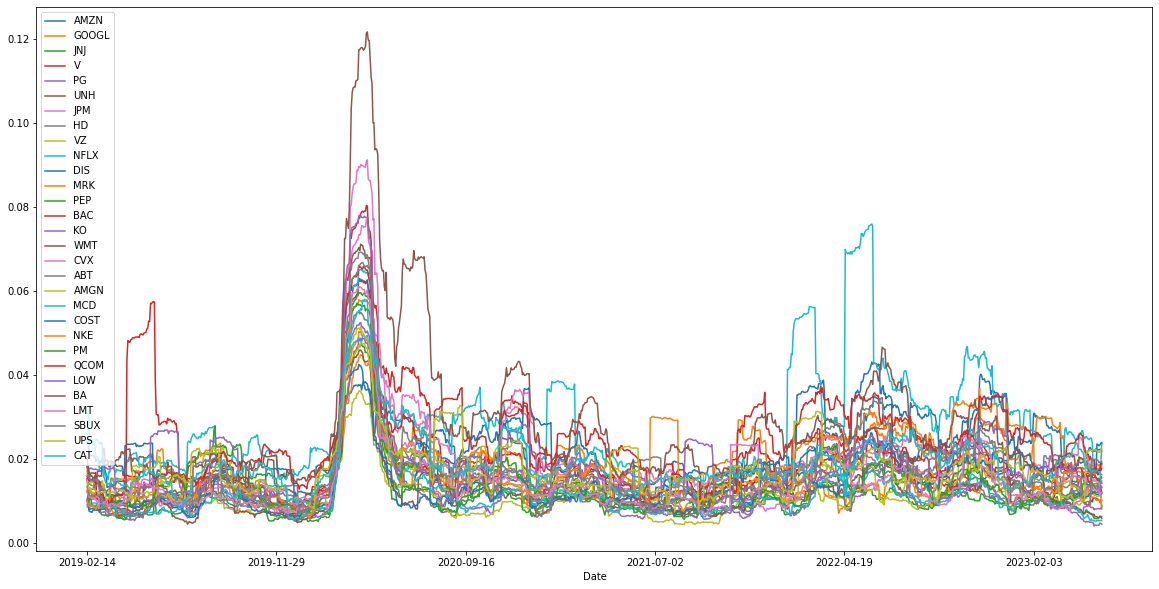

In [70]:
df_pcts.rolling(window = 30).std().dropna().plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

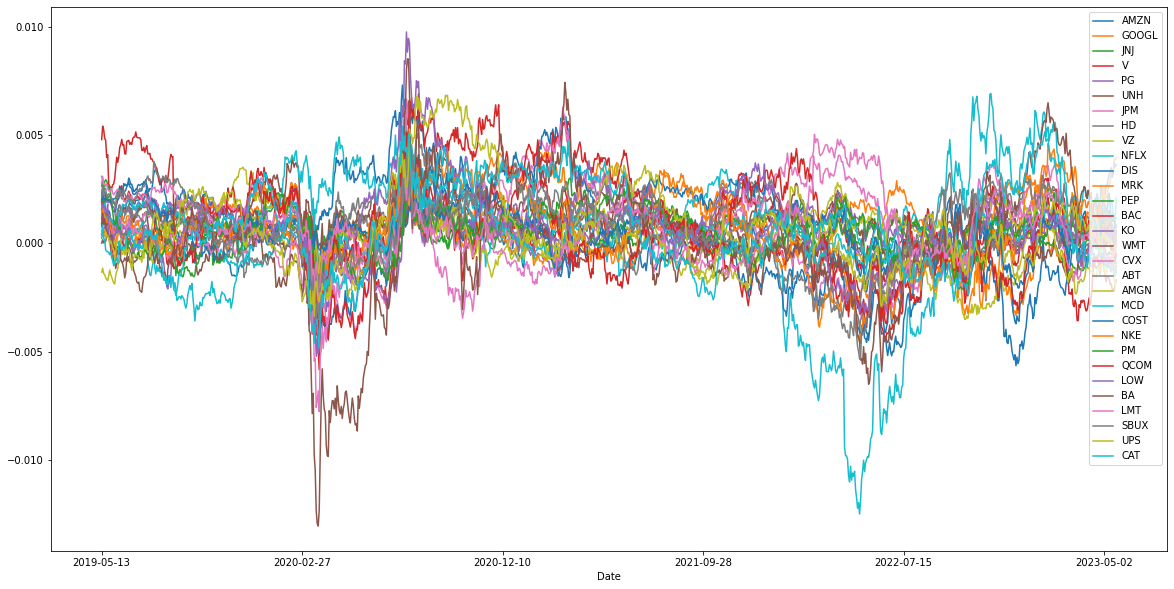

In [71]:
df_pcts.rolling(window = 90).mean().dropna().plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

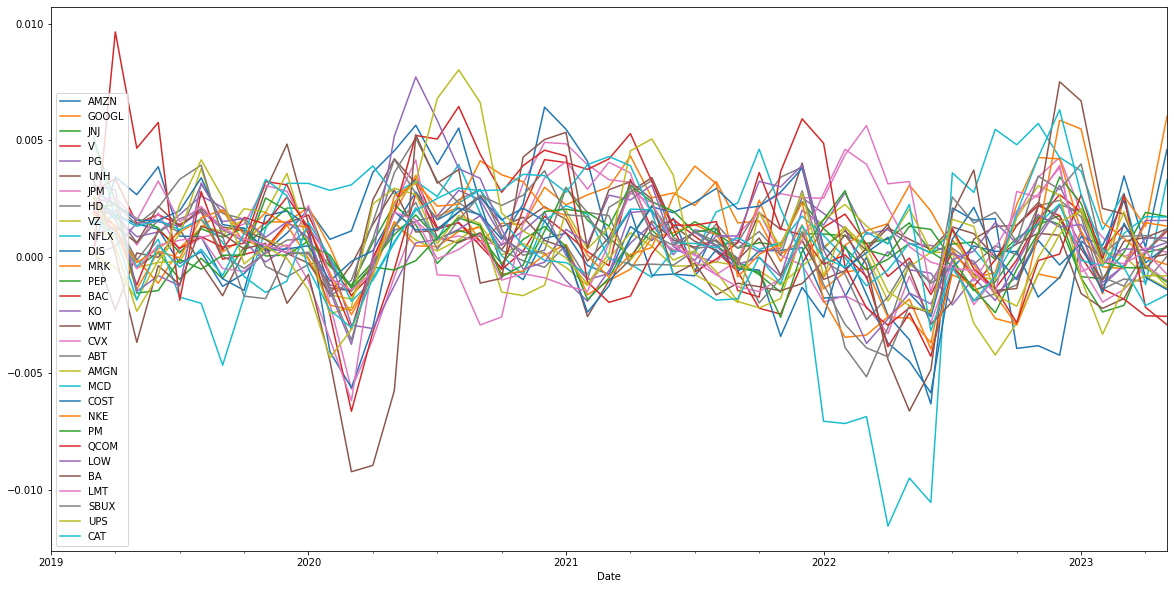

In [78]:
df_pcts.index = pd.to_datetime(df_pcts.index)



df_pcts.resample('M').mean().rolling(window = 3).mean().plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

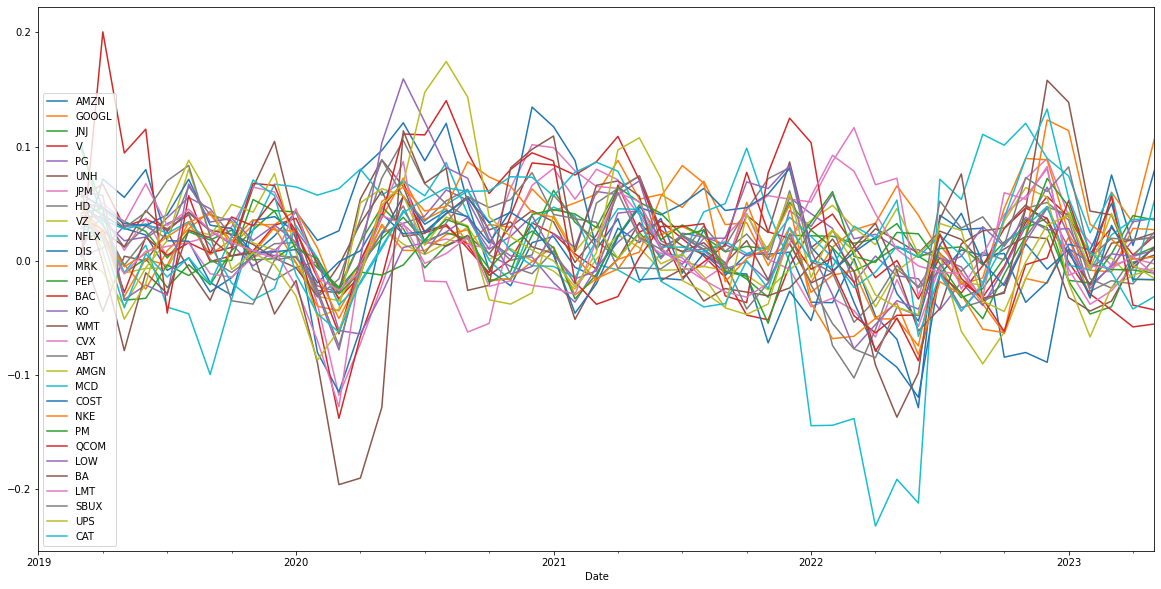

In [81]:
df_pcts.resample('M').sum().rolling(window = 3).mean().plot(figsize = (20, 10))

In [82]:
jpm = df_prices[['JPM']]

# daily return
# monthly return

# daily std 
# monthly std

# annual return
# annual std

# log return
# log std

#rolling averages

# signals

JPM
Date                  
2019-01-02   86.554703
2019-01-03   85.324608
2019-01-04   88.470131
2019-01-07   88.531639
2019-01-08   88.364693
...                ...
2023-05-12  134.100006
2023-05-15  135.229996
2023-05-16  134.320007
2023-05-17  138.449997
2023-05-18  139.500000

[1103 rows x 1 columns]